# Efektivita omezujících opatření zavedených proti šíření koronaviru

Tato analýza se věnuje efektivitě omezujících opatření zavedené v jednotlivých zemích. Především by pak tato analýza měla zodpovědět tyto otázky:

1.   Kdy začali mít účinnost nařízená opatření v dané zemi?
2.   Jak byly efektivní nařízená opatření v dané zemi?
3.   Díky kterým nařízením se docílilo tohoto poklesu v dané zemi?

Po zodpovězení těchto otázek pak bude porovnána efektivita opatření zavedená v České republice s zeměmi.

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot  as plt
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm
from fbprophet import Prophet

scripts_base_path = '/content/drive/My Drive/notebooks/lsm/semestralni_prace'

import os
import sys
sys.path.insert(0, os.path.abspath(scripts_base_path))

base_path = '/content/drive/My Drive/notebooks/lsm/semestralni_prace'

## Základní informace o datech

Jako dataset pro analýzu je použit OxCGRT ([The Oxford Covid-19 Government Response Tracker](https://github.com/OxCGRT/covid-policy-tracker)), ve kterém jsou denní informace zemí o pacientech (počet nakažených, ...), o nařízeních vlády a kdy byly provedeny.

In [104]:
df = pd.read_csv(base_path + '/data/OxCGRT_latest.csv')

Dataset obsahuje čtyři druhy příznaků o nařízeních vlády:
*   omezující/uzavírací opatření (C1 až C8)
*   ekonomické opatření (E1 až E4)
*   opatření ve zdravotním systému (H1 až H5)
*   jiná opatření (M1)

Tato analýza se bude především věnovat omezujícími/uzavíracími opatřeními v příznacích C1 až C8, které označují určité omezení např. C1 značí uzavření škol. Každý z těchto příznaků nabývá číselné hodnoty, které určují úroveň omezení, např. hodnota 0 u C1 znamená žádné omezení a hodnota 3 znamená uzavření všech škol v celé zemi.

Dataset dále obsahuje:

*   informace o 176 zemích

In [105]:
df['CountryName'].nunique()

176



*   data od 1. 1. 2020 do 8. 6. 2020



In [109]:
print(pd.to_datetime(pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')).min(), pd.to_datetime(pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')).max())

2020-01-01 00:00:00 2020-06-09 00:00:00




*   kumulativní součet nakažených a počet úmrtí k daném dni




In [117]:
df.loc[df['CountryName'] == 'Czech Republic', ['CountryName', 'Date', 'ConfirmedCases', 'ConfirmedDeaths']].tail(3)

CountryName      Date  ConfirmedCases  ConfirmedDeaths
6723  Czech Republic  20200606          9529.0            327.0
6724  Czech Republic  20200607          9567.0            327.0
6725  Czech Republic  20200608          9628.0            327.0



*   28096 záznamů, 40 číselných příznaků a 2 textové příznaky



In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28096 entries, 0 to 28095
Data columns (total 42 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CountryName                            28096 non-null  object 
 1   CountryCode                            28096 non-null  object 
 2   Date                                   28096 non-null  int64  
 3   C1_School closing                      27139 non-null  float64
 4   C1_Flag                                14033 non-null  float64
 5   C2_Workplace closing                   27129 non-null  float64
 6   C2_Flag                                12459 non-null  float64
 7   C3_Cancel public events                27113 non-null  float64
 8   C3_Flag                                14356 non-null  float64
 9   C4_Restrictions on gatherings          27115 non-null  float64
 10  C4_Flag                                12600 non-null  float64
 11  C5

## Předzpracování dat

Jak je vidět výše tak příznak M1 neobsahuje žádná data, tj. pro další analýzu je zbytečný a bude smazán.

In [119]:
df = df.drop('M1_Wildcard', axis=1)

Odstraním všechny řádky, u kterých je neznámí počet potvrzených případů nebo počet mrtvých.

In [120]:
df = df[(df['ConfirmedCases'].notna()) & (df['ConfirmedDeaths'].notna())]

Pro snadnější práci s datumem bude převeden příznak Date z int64 na datetime.

In [121]:
df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')

Abych viděl aktuální informace o každé zemi, tak si vytvořím dataframe obsahující pouze 176 záznamů ke každé zemi a jelikož k aktuálnímu datu (2020-06-09) nejsou známá všechna data, budu za "aktuální" data považovat ty z 2020-06-07.

In [122]:
df_current = df.loc[df['Date'] == '2020-06-07']

Abych viděl u každé země kdy přesně zavedli omezující opatření a v jaké podobě, tak si vytvořím dataframe obsahující záznam ke každé zemi a k nim počateční datumy zavedení konkrétní úrovně opatření. Hodnotou None pak budu značit úroveň opatření, která nebyla zavedena a nebo informace o daném opatření v zemi není dostupná.

In [123]:
df_first_dates = pd.DataFrame()

restriction_levels = {
    'C1_School closing': [1, 2, 3],
    'C2_Workplace closing': [1, 2, 3],
    'C3_Cancel public events': [1, 2],
    'C4_Restrictions on gatherings': [1, 2, 3, 4],
    'C5_Close public transport': [1, 2],
    'C6_Stay at home requirements': [1, 2, 3],
    'C7_Restrictions on internal movement': [1, 2],
    'C8_International travel controls': [1, 2, 3, 4],
}

countries = df['CountryName'].unique()
for country in countries:
    df_country = df.loc[df['CountryName'] == country]
    row_first_dates = {'Country': country}
    for restriction in restriction_levels.keys():
        for level in restriction_levels[restriction]:
            first_index = df_country.loc[df_country[restriction] == level].first_valid_index()
            row_first_dates[restriction + '_' + str(level)] = None if first_index == None else df_country.loc[first_index, 'Date']
    df_first_dates = df_first_dates.append(row_first_dates, ignore_index=True)

In [124]:
df_first_dates.loc[df_first_dates['Country'] == 'Czech Republic']

C1_School closing_1  ...         Country
41                None  ...  Czech Republic

[1 rows x 24 columns]

Nyní jsou v datasetu informace pouze o počtu nakažaných a mrtvých jako kumulativní suma k danému dni. Hodilo by se však mít informace o denních přírustkách. Tyto data získám diferencováním (pro každou zemi zvlášť) a nově vzniknuté příznaky se budou nazývat daily_increment_confirmed a daily_increment_deaths.

In [125]:
new_df = pd.DataFrame()

countries = df['CountryName'].unique()
for country in countries:
    df_country = df.loc[df['CountryName'] == country]
    df_country['daily_increment_confirmed'] = df_country['ConfirmedCases'].diff(1)
    df_country['daily_increment_deaths'] = df_country['ConfirmedDeaths'].diff(1)
    df_country = df_country.iloc[1:]
    new_df = new_df.append(df_country, ignore_index=True)

df = new_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Explorace dat



In [126]:
dist = []
xticks = [
    'C1 - Uzavírání škol', 
    'C2 - Omezení práce',   
    'C3 - Omezení veřejných akcí', 
    'C4 - Omezení shromažďování', 
    'C5 - Omezení veřejné dopravy', 
    'C6 - Omezení vycházení z domu',     
    'C7 - Omezení pohybu uvnitř země',   
    'C8 - Omezení cestovatování do jiných zemí',                     
]
for restriction in restriction_levels.keys():
    dist.append(df.loc[df[restriction].isin(restriction_levels[restriction]), 'CountryName'].nunique())
dist

[170, 162, 169, 160, 133, 157, 157, 169]

Text(0, 0.5, 'počet zemí')

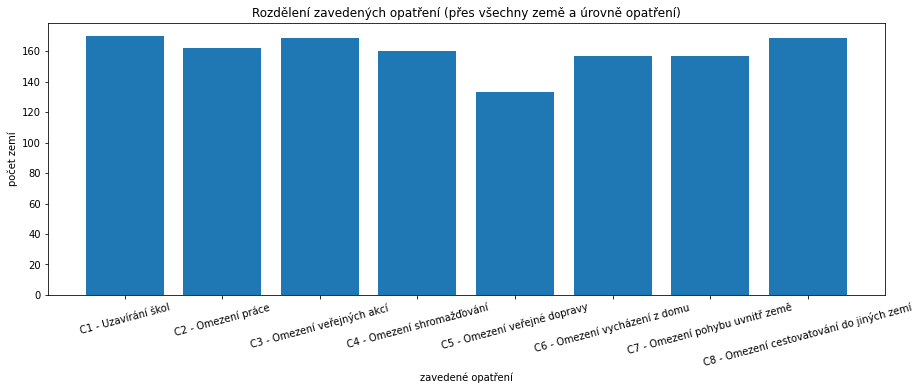

In [127]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.bar(xticks, height=dist)
axs.set_xticklabels(xticks, rotation=15)
axs.set_title('Rozdělení zavedených opatření (přes všechny země a úrovně opatření)')
axs.set_xlabel('zavedené opatření')
axs.set_ylabel('počet zemí')

Z grafu výše, zobrazující rozdělení zavedených opatření přes všechny země, je patrné, že téměř všechny země zavedly nějakou úroveň opatření v rámci každé kategorie s výjímkou kategorie C5, týkající se veřejné dopravy, u které zavedly nějakou formu omezení pouze 133 zemí.

In [128]:
def visualize_dist_restrictions_by_level(xticks, rest, title, xlabel, ylabel, rotation=15, width=0.5, fig_width=15):
    dist = []
    for level in restriction_levels[rest]:
        dist.append(df.loc[df[rest] == level, 'CountryName'].nunique())

    fig, axs = plt.subplots(1, 1, figsize=(fig_width, 5))
    axs.bar(xticks, height=dist, width=width)
    axs.set_xticklabels(xticks, rotation=rotation)
    axs.set_title(title)
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)

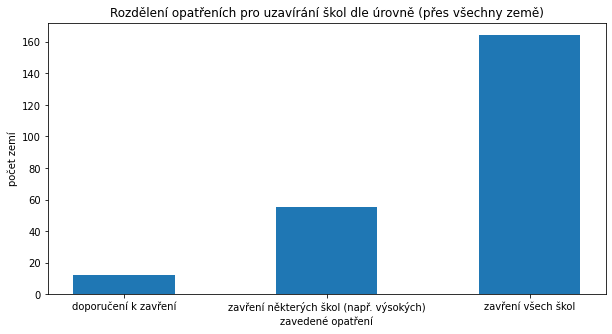

In [129]:
visualize_dist_restrictions_by_level([
    'doporučení k zavření',
    'zavření některých škol (např. výsokých)',
    'zavření všech škol',
], 'C1_School closing', 'Rozdělení opatřeních pro uzavírání škol dle úrovně (přes všechny země)', 'zavedené opatření', 'počet zemí', rotation=0, fig_width=10)

Graf výše, zobrazuje rozdělení opatření pro uzavírání škol dle úrovně přes všechny země, kde je vidět, že nejčastější úrovní bylo uzavření všech škol.

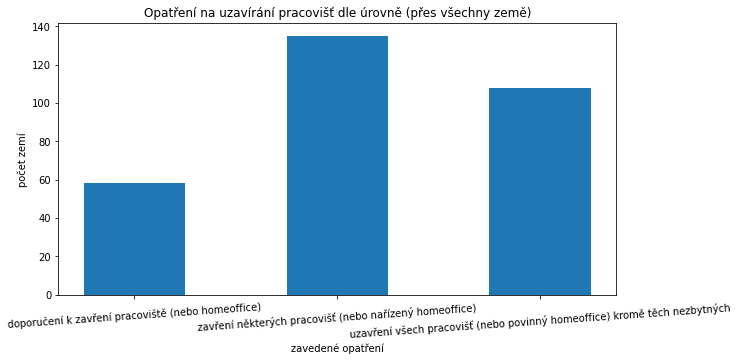

In [130]:
visualize_dist_restrictions_by_level([
    'doporučení k zavření pracoviště (nebo homeoffice)',
    'zavření některých pracovišť (nebo nařízený homeoffice)',
    'uzavření všech pracovišť (nebo povinný homeoffice) kromě těch nezbytných',
], 'C2_Workplace closing', 'Opatření na uzavírání pracovišť dle úrovně (přes všechny země)', 'zavedené opatření', 'počet zemí', rotation=4, fig_width=10)

Zde je z grafu vidět, že uzavření pouze některých pracovišť bylo zařazeno většinou zemí nejčastěji. Druhé nejčastější bylo uzavření všech pracovišť vyjma těch nezbytných.

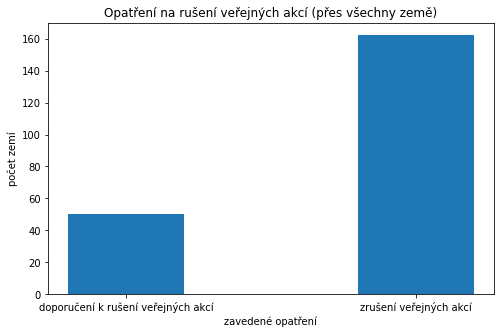

In [131]:
visualize_dist_restrictions_by_level([
    'doporučení k rušení veřejných akcí',
    'zrušení veřejných akcí',
], 'C3_Cancel public events', 'Opatření na rušení veřejných akcí (přes všechny země)', 'zavedené opatření', 'počet zemí', rotation=0, width=0.4, fig_width=8)

Z grafu výše je patrné, že téměř všechny státy zařadily nařízení o zrušení veřejných akcí.

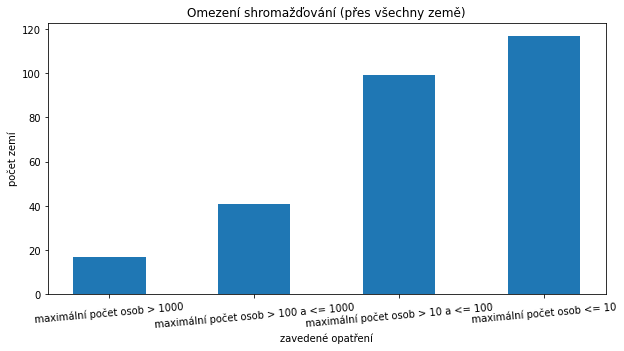

In [132]:
visualize_dist_restrictions_by_level([
    'maximální počet osob > 1000',
    'maximální počet osob > 100 a <= 1000',
    'maximální počet osob > 10 a <= 100',
    'maximální počet osob <= 10',
], 'C4_Restrictions on gatherings', 'Omezení shromažďování (přes všechny země)', 'zavedené opatření', 'počet zemí', rotation=5, fig_width=10)

Nejčastější nařízené omezení pro shromaždění maximálního počtu osob bylo 10 a 100.

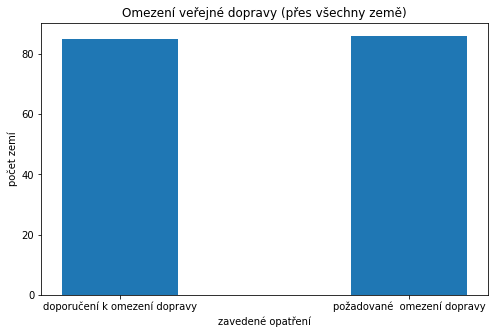

In [133]:
visualize_dist_restrictions_by_level([
    'doporučení k omezení dopravy',
    'požadované  omezení dopravy',
], 'C5_Close public transport', 'Omezení veřejné dopravy (přes všechny země)', 'zavedené opatření', 'počet zemí', rotation=0, width=0.4, fig_width=8)

U omezení veřejné dopravy je počet nařízení/doporučení přibližně stejný.

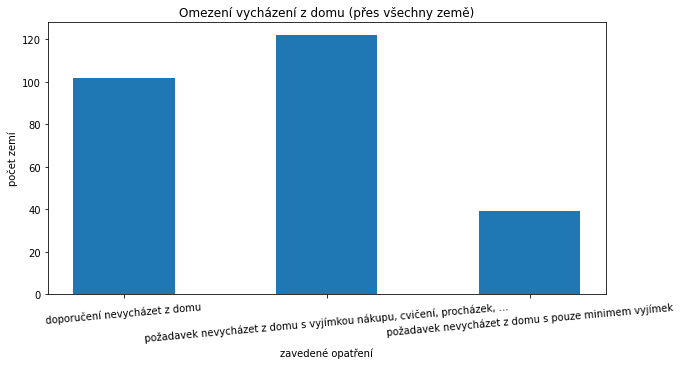

In [134]:
visualize_dist_restrictions_by_level([
    'doporučení nevycházet z domu',
    'požadavek nevycházet z domu s vyjímkou nákupu, cvičení, procházek, ...',
    'požadavek nevycházet z domu s pouze minimem vyjímek',
], 'C6_Stay at home requirements', 'Omezení vycházení z domu (přes všechny země)', 'zavedené opatření', 'počet zemí', rotation=5, fig_width=10)

Z grafu výše je vidět, že nejčastější nařízení bylo zákaz vycházení z domu s výjímkou nákupu, cvičení, atd. Druhým nejčastějším bylo pouze vydání doporučení na nevycházení z domu.

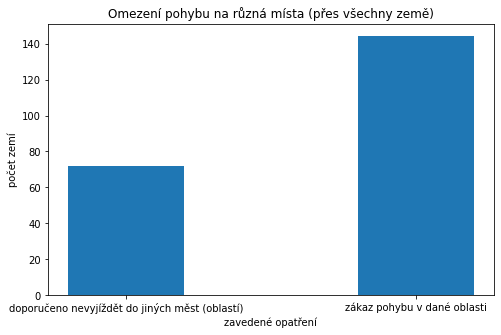

In [135]:
visualize_dist_restrictions_by_level([
    'doporučeno nevyjíždět do jiných měst (oblastí)',
    'zákaz pohybu v dané oblasti'
], 'C7_Restrictions on internal movement', 'Omezení pohybu na různá místa (přes všechny země)', 'zavedené opatření', 'počet zemí', rotation=0, width=0.4, fig_width=8)

Většína zemí nařídila omezení pohybu v určitých oblastech.

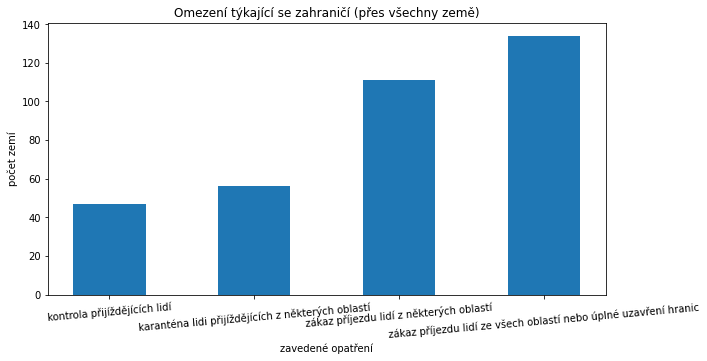

In [136]:
visualize_dist_restrictions_by_level([
    'kontrola přijíždějících lidí',
    'karanténa lidi přijíždějících z některých oblastí',
    'zákaz příjezdu lidí z některých oblastí',
    'zákaz příjezdu lidí ze všech oblastí nebo úplné uzavření hranic',
], 'C8_International travel controls', 'Omezení týkající se zahraničí (přes všechny země)', 'zavedené opatření', 'počet zemí', rotation=5, fig_width=10)

Z grafu výše je vidět, že nejčastější nařízení bylo zákaz příjezdu lidí ze zahraničí nebo úplné uzavření hranic. Druhým nejčastějším bylo pouze zákaz příjezdu lidí z určitých zemí.

Text(0, 0.5, 'počet mrtvých')

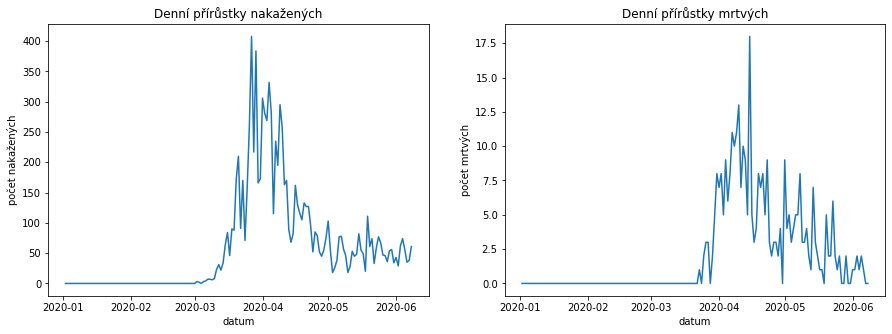

In [137]:
df_country = df.loc[df['CountryName'] == 'Czech Republic']
ts_conf = df_country[['daily_increment_confirmed', 'Date']].set_index('Date')
ts_death = df_country[['daily_increment_deaths', 'Date']].set_index('Date')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(ts_conf)
axs[0].set_title('Denní přírůstky nakažených')
axs[0].set_xlabel('datum')
axs[0].set_ylabel('počet nakažených')

axs[1].plot(ts_death)
axs[1].set_title('Denní přírůstky mrtvých')
axs[1].set_xlabel('datum')
axs[1].set_ylabel('počet mrtvých')

Grafy výše ukazují denní přírůstky nakažených a mrtvých v České republice od ledna do června.

## Kdy začali mít účinnost nařízená opatření v dané zemi?

Účinek opatření se neprojeví okamžitě přístí den, denní přírůstky tedy budou seskupeny podle týdne. Výstupem pak tedy bude týden T, kdy začali mít účinnost nařízená opatření (např. týden s nejvyšším přírůstkem). Pro nalezení takového týdne je použit následující postup:

1. Data denních přírůstků se seskupí podle týdne.
2. Spočítá se velikost změny denního přírůstku.
3. Spočítá se rychlost změny vypočítaná v kroku 2.
4. Analyzuje se časový průběh týdeních dat:
    * nalezne se takový týden T s denním přírůstkem x, od něhož budou mít aspoň čtyři další týdny denní přírůstky menší nebo rovny x

In [138]:
def get_group_data(data, country, group_by='W'):
    df_country = data.loc[data['CountryName'] == country].set_index('Date')
    inc = pd.DataFrame()
    inc['increment'] = df_country['daily_increment_confirmed'].resample(group_by).sum()
    inc['diff_1'] = inc['increment'].diff(1)
    inc = inc.dropna()
    inc['diff_2'] = inc['diff_1'].diff(1)
    inc = inc.dropna()
    inc['group_num'] = range(1, len(inc)+1)
    if group_by == 'W':
        inc = inc.drop(inc.last_valid_index())
    return inc

def visualize_increment(data):
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    axs.plot(data['increment'], label='denní přírůstek', marker="o")
    axs.plot(data['diff_1'], label='velikost změny přírůstku', marker="o")
    axs.plot(data['diff_2'], label='rychlost velikosti změny', marker="o")
    axs.set_title('Vývoj denních přírůstků počtu nakažených')
    axs.set_xlabel('Datum')
    axs.set_ylabel('počet nakažených')
    axs.legend()

def country_summary_visualization(data, country):
    weekly_inc = get_group_data(data, country)
    visualize_increment(weekly_inc)

## Jak byly efektivní nařízená opatření v dané zemi?

Efektivita bude měřena metrikou Average Percent Change (APC), která určí průměrnou procentuální změnu v určitém intervalu (průměr procentuálních změn sousedních týdnů). V tomto případě budou vypočítány dvě APC ze dvou intervalů. První APC v intervalu od prvního týdne s aspoň 50 nakaženými až po týden T a druhý APC v intervalu T až T + 4.

In [155]:
def avg_roc(data, point1_index, point2_index):
    if point1_index not in data['increment'].index or point2_index not in data['increment'].index:
        raise Exception("One of the points are not in index.") 

    y2 = data['increment'][point2_index]
    y1 = data['increment'][point1_index]
    x2 = data['group_num'][point2_index]
    x1 = data['group_num'][point1_index]
    return (y1 - y2) / (x1 - x2)

def avg_percent_change(data, point1_index, point2_index):
    first = point1_index
    second = point1_index + pd.to_timedelta(1, unit="W")
    percent_changes = []

    while second <= point2_index and first in data['increment'].index and second in data['increment'].index:
        y2 = data['increment'][second]
        y1 = data['increment'][first]
        if y2 > 50 and y1 > 50:
            percent_change = ((y2 - y1) / (y2 if y1 == 0 else y1)) * 100
            percent_changes.append(percent_change)
        first = first + pd.to_timedelta(1, unit="W")
        second = second + pd.to_timedelta(1, unit="W")

    return np.mean(percent_changes)

def country_summary_change(data, country, max_point=None):
    weekly_inc = get_group_data(data, country)
    max_point = max_point if max_point else weekly_inc['increment'].idxmax()

    # weekly_inc.loc[weekly_inc['increment'] != 0].first_valid_index()   max_point - pd.to_timedelta(4, unit="W")
    avg_percent_change_inc_to_max = avg_percent_change(weekly_inc, weekly_inc.loc[weekly_inc['increment'] >= 50].first_valid_index(), max_point)
    avg_percent_change_inc_from_max = avg_percent_change(weekly_inc, max_point, max_point + pd.to_timedelta(4, unit="W"))
    avg_roc_inc_to_max = avg_roc(weekly_inc, weekly_inc.loc[weekly_inc['increment']  >= 50].first_valid_index() - pd.to_timedelta(1, unit="W"), max_point)
    avg_roc_inc_from_max = avg_roc(weekly_inc, max_point, max_point + pd.to_timedelta(4, unit="W"))  

    print('APC v intervalu od prvního týdne s aspoň 50 nakaženými až po týden T:', avg_percent_change_inc_to_max)
    print('APC v intervalu od týdne T do týdne T + 4:', avg_percent_change_inc_from_max)
    print('Average ROC z prvního týdne s aspoň 50 nakaženými a týdne T:', avg_roc_inc_to_max)
    print('Average ROC z týdne T a týdne T + 4:', avg_roc_inc_from_max)    

    return pd.DataFrame({
        'APC': [avg_percent_change_inc_to_max, avg_percent_change_inc_from_max], 
        'avg_roc': [avg_roc_inc_to_max, avg_roc_inc_from_max],
        'type': ['to', 'from'], 
        'country': [country, country],
    })

In [156]:
result_changes = pd.DataFrame()

## Díky kterým nařízením se docílilo tohoto poklesu v dané zemi?

Budou se hledat kombinace nařízení (C1 až C8), které byly zavedeny 4 týdny před a 4 týdny po týdnu kdy začali mít účinnost (viz týden T z odpovědi výše). Výsledkem tedy budou dvě kombinace, jedna která předcházela zlepšení a druhá, díky které se dále dařilo sniživat množství nakažených. Jednotlivé položky kombinace jsou určeny dle nejčastější úrovně daného opatření ve zmíněném intervalu, tj. pokud budou např. uzavřeny všechny školy většinu dnů v těch čtyřech týdnech, bude pak tato úroveň považována za tu, díky které bylo docíleno tohoto poklesu nebo zmírnění.

In [157]:
def get_restrictions(data, country, point, rest_names):
    df_country = data[data['CountryName'] == country].set_index('Date')
    date_from = point - pd.to_timedelta(4, unit="W")
    date_to = point + pd.to_timedelta(4, unit="W")

    restrictions = {'country': [country, country], 'type': ['from', 'to']}
    for rest_name in rest_names:
        restrictions[rest_name] = []
        restrictions[rest_name].append(df_country.loc[date_from:point, rest_name].value_counts().idxmax())
        restrictions[rest_name].append(df_country.loc[point:date_to, rest_name].value_counts().idxmax())

    return pd.DataFrame(restrictions)

In [158]:
result_restrictions = pd.DataFrame()

## Hledání odpovědí pro Českou republiku




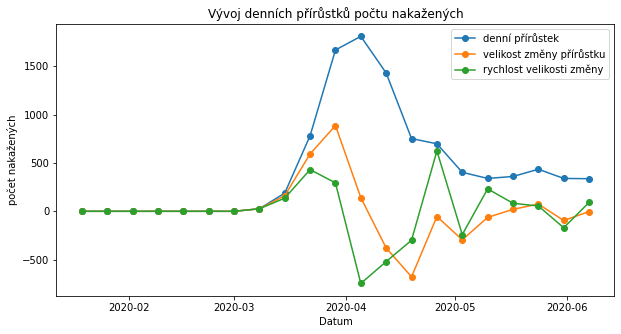

In [159]:
weekly_inc = get_group_data(df, 'Czech Republic')
country_summary_visualization(df, 'Czech Republic')

týden, kdy začali mít účinnost daná opatření:


In [160]:
week = weekly_inc['increment'].idxmax()
week

Timestamp('2020-04-05 00:00:00', freq='W-SUN')

efektivita opatření:

In [161]:
summary_change = country_summary_change(df, 'Czech Republic')
result_changes = result_changes.append(summary_change, ignore_index=True)

APC v intervalu od prvního týdne s aspoň 50 nakaženými až po týden T: 145.81703749159115
APC v intervalu od týdne T do týdne T + 4: -29.451962584854982
Average ROC z prvního týdne s aspoň 50 nakaženými a týdne T: 445.75
Average ROC z týdne T a týdne T + 4: -351.5


opatření, která byla zavedena:

In [162]:
restrictions = get_restrictions(df, 'Czech Republic', week, restriction_levels.keys())
result_restrictions = result_restrictions.append(restrictions, ignore_index=True)
restrictions

country  ... C8_International travel controls
0  Czech Republic  ...                              4.0
1  Czech Republic  ...                              2.0

[2 rows x 10 columns]

## Hledání odpovědí pro Švédsko





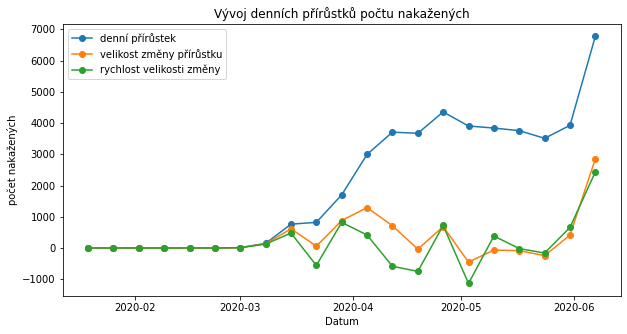

In [163]:
weekly_inc = get_group_data(df, 'Sweden')
country_summary_visualization(df, 'Sweden')

týden, kdy začali mít účinnost daná opatření:

In [164]:
week = weekly_inc['increment'].nlargest(2).index[1]
week

Timestamp('2020-04-26 00:00:00', freq='-6W-SUN')

efektivita opatření:

In [165]:
summary_change = country_summary_change(df, 'Sweden', max_point=pd.Timestamp('2020-04-26', freq='W-SUN'))
result_changes = result_changes.append(summary_change, ignore_index=True)

APC v intervalu od prvního týdne s aspoň 50 nakaženými až po týden T: 92.5341244874743
APC v intervalu od týdne T do týdne T + 4: -5.177002383718291
Average ROC z prvního týdne s aspoň 50 nakaženými a týdne T: 542.875
Average ROC z týdne T a týdne T + 4: -211.0


opatření, která byla zavedena:

In [166]:
restrictions = get_restrictions(df, 'Sweden', week, restriction_levels.keys())
result_restrictions = result_restrictions.append(restrictions, ignore_index=True)
restrictions

country  ... C8_International travel controls
0  Sweden  ...                              3.0
1  Sweden  ...                              3.0

[2 rows x 10 columns]

## Hledání odpovědí pro Francii

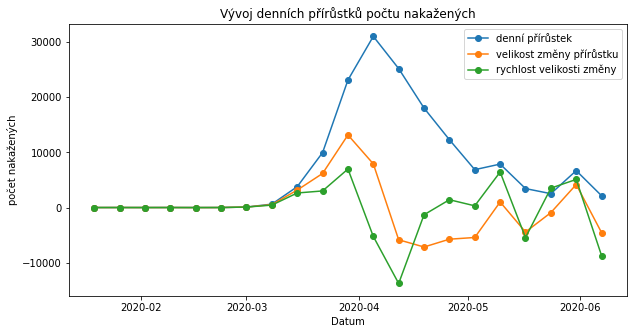

In [167]:
weekly_inc = get_group_data(df, 'France')
country_summary_visualization(df, 'France')

týden, kdy začali mít účinnost daná opatření:



In [168]:
week = weekly_inc['increment'].idxmax()
week

Timestamp('2020-04-05 00:00:00', freq='W-SUN')

efektivita opatření:

In [169]:
summary_change = country_summary_change(df, 'France')
result_changes = result_changes.append(summary_change, ignore_index=True)

APC v intervalu od prvního týdne s aspoň 50 nakaženými až po týden T: 288.74617313505087
APC v intervalu od týdne T do týdne T + 4: -30.805147166309904
Average ROC z prvního týdne s aspoň 50 nakaženými a týdne T: 5171.5
Average ROC z týdne T a týdne T + 4: -6041.25


opatření, která byla zavedena:

In [170]:
restrictions = get_restrictions(df, 'France', week, restriction_levels.keys())
result_restrictions = result_restrictions.append(restrictions, ignore_index=True)
restrictions

country  ... C8_International travel controls
0  France  ...                              4.0
1  France  ...                              4.0

[2 rows x 10 columns]

## Hledání odpovědí pro Německo

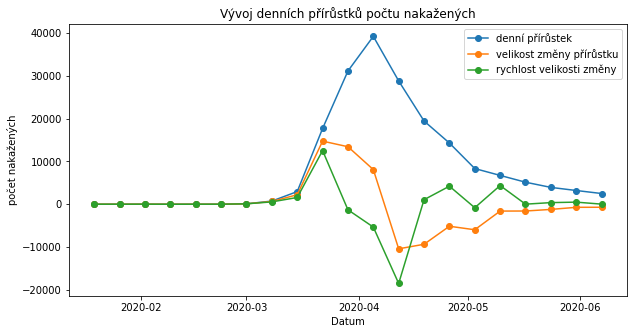

In [171]:
weekly_inc = get_group_data(df, 'Germany')
country_summary_visualization(df, 'Germany')

týden, kdy začali mít účinnost daná opatření:

In [172]:
week = weekly_inc['increment'].idxmax()
week

Timestamp('2020-04-05 00:00:00', freq='W-SUN')

efektivita opatření:

In [173]:
summary_change = country_summary_change(df, 'Germany')
result_changes = result_changes.append(summary_change, ignore_index=True)

APC v intervalu od prvního týdne s aspoň 50 nakaženými až po týden T: 313.6938684962348
APC v intervalu od týdne T do týdne T + 4: -31.81105938700035
Average ROC z prvního týdne s aspoň 50 nakaženými a týdne T: 6527.833333333333
Average ROC z týdne T a týdne T + 4: -7711.5


opatření, která byla zavedena:

In [174]:
restrictions = get_restrictions(df, 'Germany', week, restriction_levels.keys())
result_restrictions = result_restrictions.append(restrictions, ignore_index=True)
restrictions

country  ... C8_International travel controls
0  Germany  ...                              4.0
1  Germany  ...                              4.0

[2 rows x 10 columns]

## Hledání odpovědí pro Španělsko

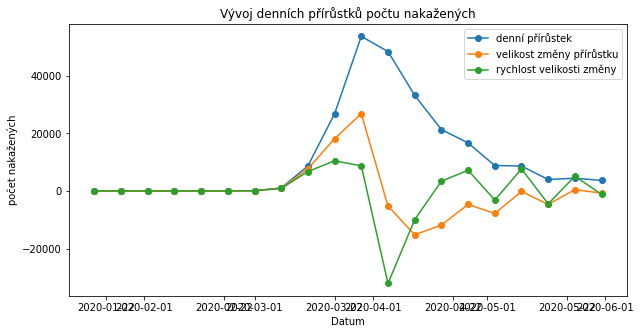

In [175]:
weekly_inc = get_group_data(df, 'Spain')
country_summary_visualization(df, 'Spain')

týden, kdy začali mít účinnost daná opatření:

In [176]:
week = weekly_inc['increment'].idxmax()
week

Timestamp('2020-03-29 00:00:00', freq='W-SUN')

efektivita opatření:

In [177]:
summary_change = country_summary_change(df, 'Spain')
result_changes = result_changes.append(summary_change, ignore_index=True)

APC v intervalu od prvního týdne s aspoň 50 nakaženými až po týden T: 558.1579176229035
APC v intervalu od týdne T do týdne T + 4: -24.727855830974995
Average ROC z prvního týdne s aspoň 50 nakaženými a týdne T: 10738.6
Average ROC z týdne T a týdne T + 4: -9258.75


opatření, která byla zavedena:

In [178]:
restrictions = get_restrictions(df, 'Spain', week, restriction_levels.keys())
result_restrictions = result_restrictions.append(restrictions, ignore_index=True)
restrictions

country  ... C8_International travel controls
0   Spain  ...                              4.0
1   Spain  ...                              4.0

[2 rows x 10 columns]

## Porovnání efektivity opatření zavedená v České republice s jinými zeměmi

In [179]:
def visualize_countries_apc_and_avg_roc(xticks, apcs, avg_rocs, title1, title2):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].bar(xticks, height=apcs, width=0.3)
    axs[0].set_title(title1)
    axs[0].set_xlabel('země')
    axs[0].set_ylabel('APC')
    axs[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: str(y) + ' %'))

    axs[1].bar(xticks, height=avg_rocs, width=0.3)
    axs[1].set_title(title2)
    axs[1].set_xlabel('země')
    axs[1].set_ylabel('Průměrný ROC')

porovnávané země:

In [180]:
result_changes['country'].unique()

array(['Czech Republic', 'Sweden', 'France', 'Germany', 'Spain'],
      dtype=object)

## Období od počátku nákazy po týden T

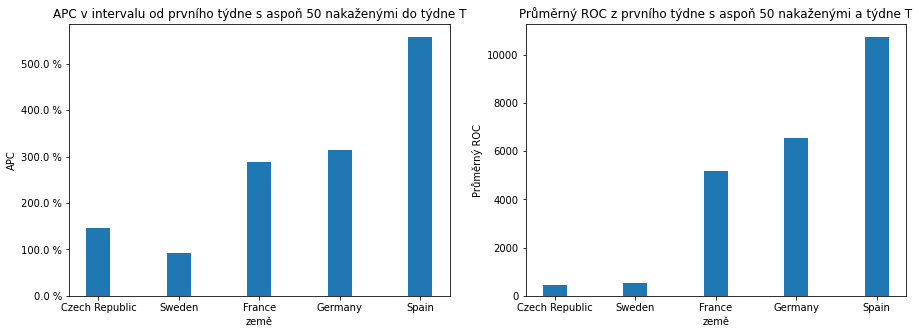

In [181]:
result_changes_to = result_changes.loc[result_changes['type'] == 'to', ['APC', 'avg_roc', 'country']]
xticks = result_changes_to['country']
visualize_countries_apc_and_avg_roc(xticks, result_changes_to['APC'], result_changes_to['avg_roc'], 'APC v intervalu od prvního týdne s aspoň 50 nakaženými do týdne T', 'Průměrný ROC z prvního týdne s aspoň 50 nakaženými a týdne T')

In [182]:
result_changes_to

APC       avg_roc         country
0  145.817037    445.750000  Czech Republic
2   92.534124    542.875000          Sweden
4  288.746173   5171.500000          France
6  313.693868   6527.833333         Germany
8  558.157918  10738.600000           Spain

In [183]:
result_restrictions.loc[result_restrictions['type'] == 'to']

country  ... C8_International travel controls
1  Czech Republic  ...                              2.0
3          Sweden  ...                              3.0
5          France  ...                              4.0
7         Germany  ...                              4.0
9           Spain  ...                              4.0

[5 rows x 10 columns]

Zde je vidět, že Česká republika v období od počátku nákazy po týden T má spolu se Švédskem nejnižší APC nepřevyšující 150 %, kdežto ostatní země mají APC přibližně nad 300 %. Česká republika se Švédskem přitom mají v tomto období nejmírnější opatření především pak u C7 a C8.

Nejefektivnější opatření:


In [184]:
result_restrictions.loc[result_restrictions['type'] == 'to'].iloc[:2, 2:]

C1_School closing  ...  C8_International travel controls
1                3.0  ...                               2.0
3                1.0  ...                               3.0

[2 rows x 8 columns]

## Období od týdne T do týdne T + 4

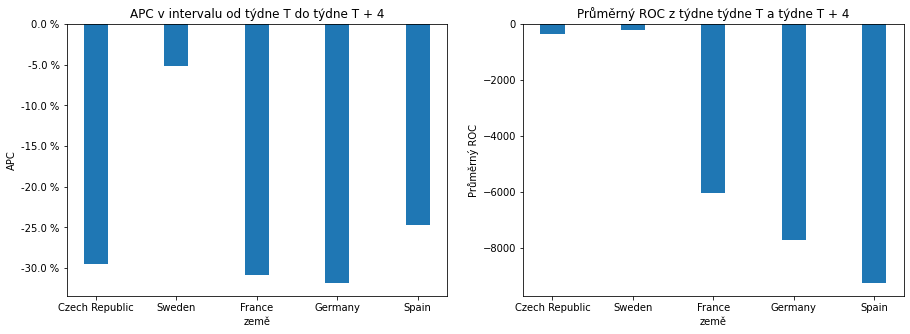

In [185]:
result_changes_from = result_changes.loc[result_changes['type'] == 'from']
xticks = result_changes_from['country']
visualize_countries_apc_and_avg_roc(xticks, result_changes_from['APC'], result_changes_from['avg_roc'], 'APC v intervalu od týdne T do týdne T + 4', 'Průměrný ROC z týdne týdne T a týdne T + 4')

In [186]:
result_changes_from

APC  avg_roc  type         country
1 -29.451963  -351.50  from  Czech Republic
3  -5.177002  -211.00  from          Sweden
5 -30.805147 -6041.25  from          France
7 -31.811059 -7711.50  from         Germany
9 -24.727856 -9258.75  from           Spain

In [187]:
result_restrictions.loc[result_restrictions['type'] == 'from']

country  ... C8_International travel controls
0  Czech Republic  ...                              4.0
2          Sweden  ...                              3.0
4          France  ...                              4.0
6         Germany  ...                              4.0
8           Spain  ...                              4.0

[5 rows x 10 columns]



V tomto období od týdne T do týdne T + 4 dosahuje Česká republika spolu s Francií a Německem nejnižší APC okolo -30 %, Španělsko pak má APC -25 % a Švédsko má pokles pouze -5 %. Česká republika spolu s Francií a Německem mají přibližně stejná omezení. Španělsko nejspíše kvůli uvolnění C4 (omezení shromaždování) z hodnoty 4 na 1 způsobilo snízění efektivity o 5 % oproti České republice. Švédsko pak má v tomto období stále mírné nařízení avšak s nejhorším výsledkem.

Nejefektivnější opatření:

In [188]:
result_restrictions.loc[(result_restrictions['type'] == 'from') & (result_restrictions['country'].isin(['Czech Republic', 'France', 'Germany']))].iloc[:, 2:]

C1_School closing  ...  C8_International travel controls
0                3.0  ...                               4.0
4                3.0  ...                               4.0
6                3.0  ...                               4.0

[3 rows x 8 columns]

## Závěr

V této analýze se hledali odpovědi na uvedené otázky v úvodu pro Českou republiku, Švédsko, Francii, Německo a Španělsko. Nejprve se nastavila metodika podle které bylo odpovídáno na otázky. Poté se u každé země podle té metodiky zkoumala efektivita zavedených nářízení v prvním období od počátku nákazy až po týden T a ve druhém období od T po T + 4. Následně pak byla porovnána efektivita nařízení jednotlivých zemí v těchto dvou obdobích.

Z porovnání efektivity vyplynulo, že v prvním období byly nejefektivnější Česká republika spolu se Švédskem, které měli nejmírnější omezení a přesto dosáhli nejlepší APC. Ve druhém období pak srovnatelně nejefektivnější byly Česká republika, Francie a Německo, které díky striktnějším opatřením dosáhly nejlepšího APC. Výrazně nejhorším výsledkem ve druhém období dosáhlo Švédsko se svými mírnými opatřeními.